# Predicting the likelihood that a target audience clicks on an Ad

# Part 1 - DEFINE

Media conglomerate company X has a network of different websites within its network and would like to run a certain ad for company A which is selling product M. The company is willing to pay the media company 25USD for each successful click that leads the traffic to their site up to a maximum of 40000USD and is looking to create awareness about product M. Company X has 10 websites within its network that have a target audience that would be likely to click on the ad based on data from previous campaigns with companies selling similar products.

The dataset provided is a subset of data from one of the sites. Company A is also looking to run on only two websites of the 10 for a start and if this proves successful they would be willing to spend more money to run the ad on other website that have a similar audience based on the results.
The media conglomerate would like a model saved in a pickle that they can use to test on the data they have from other websites to see which websites are likely to have a higher number of clicks. This would ensure that they run the ads on the top 2 websites where they are likely to get the highest number of clicks and therefore secure the full amount of 40000USD. 

**Accuracy** in this model is therefore particularly important and thus the focus is the True Positives. 
**False positives** on the other hand would likely lose revenue for the company in this case about 25USD per misclassified click. 
If the goal of about 1600 clicks is not reached by this campaign it potentially lose any future business with Company A estimated at a minimum of 300000USD per year.

Assumption: This data is a sample from one of the websites to ensure a balanced dataset based on the target variable.


Below is a summary of the features in the dataset:

* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': customer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether the consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

Assumption: The media company is paid per click by the advertiser.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import time
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

-----

## Part 2 - DISCOVER

### Load the data 

In [2]:
#loading the data
ad_data = pd.read_csv('advertising.csv')
ad_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [3]:
ad_data.shape

(1018, 10)

In [4]:
ad_data = ad_data.rename(columns={'Daily Time Spent on Site': 'time_on_site',
                                 'Daily Internet Usage': 'internet_usage',
                                 'Age': 'age',
                                 'Area Income': 'area_income',
                                 'Ad Topic Line': 'ad_topic_line',
                                 'City': 'city',
                                 'Male': 'male',
                                 'Country': 'country',
                                 'Timestamp': 'timestamp',
                                 'Clicked on Ad': 'clicked'})

------

### Clean the data

In [5]:
#ad data summary statistics to aid in cleaning the data
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_on_site    1018 non-null   float64
 1   age             1018 non-null   int64  
 2   area_income     1018 non-null   float64
 3   internet_usage  1018 non-null   float64
 4   ad_topic_line   1018 non-null   object 
 5   city            1018 non-null   object 
 6   male            1018 non-null   int64  
 7   country         1018 non-null   object 
 8   timestamp       1018 non-null   object 
 9   clicked         1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB


In [6]:
#4 values are missing the target variable and will not be useful for predicting
ad_data = ad_data.dropna(axis=0)
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_on_site    1014 non-null   float64
 1   age             1014 non-null   int64  
 2   area_income     1014 non-null   float64
 3   internet_usage  1014 non-null   float64
 4   ad_topic_line   1014 non-null   object 
 5   city            1014 non-null   object 
 6   male            1014 non-null   int64  
 7   country         1014 non-null   object 
 8   timestamp       1014 non-null   object 
 9   clicked         1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 87.1+ KB


In [7]:
#checking for duplicated records
ad_data.duplicated().sum()

7

In [8]:
ad_data = ad_data.drop_duplicates()
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_on_site    1007 non-null   float64
 1   age             1007 non-null   int64  
 2   area_income     1007 non-null   float64
 3   internet_usage  1007 non-null   float64
 4   ad_topic_line   1007 non-null   object 
 5   city            1007 non-null   object 
 6   male            1007 non-null   int64  
 7   country         1007 non-null   object 
 8   timestamp       1007 non-null   object 
 9   clicked         1007 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 86.5+ KB


-----

### Exploratory Data Analysis

In [9]:
#target feature distribution
click_rate = ad_data['clicked'].value_counts()/ad_data.shape[0]
click_rate

1.0    0.502483
0.0    0.497517
Name: clicked, dtype: float64

The dataset seems to be almost evenly distributed between the target audience that clicked on the ad and those that did not and therefore there will be no need to work on class imbalance

In [10]:
ad_data.describe()

,time_on_site,age,area_income,internet_usage,male,clicked
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,0.502483
std,15.850441,31.729539,13458.555374,44.548765,0.499946,0.500242
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


The age column seems to have a min value that is not valid. Based on most advertising standards/clients (need to verify this). We do not target consumers below the age of 18, the max value is also suspect since it is 999.

In [11]:
#closer look at the target audience below the age of 18
#set the age limit to 18
ad_data.age.sort_values().head()

294   -25
823     8
713    19
358    19
785    19
Name: age, dtype: int64

In [12]:
ad_data.age.sort_values(ascending=False).head()
#there are two values that are above 100

495    999
604    103
684     61
185     60
635     60
Name: age, dtype: int64

In [13]:
#remove the extra age values
ad_data = ad_data[(ad_data['age'] >= 18) & (ad_data['age'] < 100)]

In [14]:
#the daily time spent on the site by a consumer should be less than the daily time spent on the internet by the consumer
ad_data['delta'] = ad_data['internet_usage'] - ad_data['time_on_site']

In [15]:
sum(ad_data['delta'] < 0)

3

In [16]:
#remove the three observations in the data where the daily internet usage is less than the time spent on site
ad_data = ad_data[ad_data['delta'] >= 0]

In [17]:
#interesting feature to include at would be what percentage of the time spent on the internet is spent on the site
#time on site/time on internet
ad_data = ad_data.drop('delta', axis=1)
ad_data.head()

,time_on_site,age,area_income,internet_usage,ad_topic_line,city,male,country,timestamp,clicked
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [18]:
#summary of the categorical features
ad_data.describe(include='object')

,ad_topic_line,city,country,timestamp
count,1000,1000,1000,1000
unique,1000,969,237,997
top,Polarized multimedia system engine,Lisamouth,France,2016-05-30 8:02
freq,1,3,9,2


Based on the above information, the ad topic line had 1000, different values and would not be the best indicator of whether a consumer clicked on an ad since it seems that they were all running different ad copy. However, closer investigation using Natural Language Processing might reveal more which I will not pursue in this project. 

The consumers are from 696 different cities except for about 31 which also would mean that this would not be the best indicator of whether they click on an ad.
For this project, I will not explore whether the country that a consumer is in affected their decision to click on an ad. The assumption is that the client's product is sold globably and online and so is the media company that is running the ad. Therefore people from different countries have access to it and would be equally inclined to click on the ad.

This project will also not be focused on the time of day. Time series analysis would however, be useful in carrying out further analysis.

-----

### EDA Vizualizations

In [19]:
num_vars = ['time_on_site', 'age', 'area_income', 'internet_usage']
cat_vars = ['male', 'clicked']
target = ['clicked']

In [20]:
#create a function to show the distribution of features to investigate the presence of outliers
#function seems to only plot two items (investigate why a third feature is not plotted)
def plots(feature):
    for item in numerical_data:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        sns.distplot(item, color = 'blue')
        
        plt.subplot(1,2,2)
        sns.boxplot(item, color='red')
        plt.show()

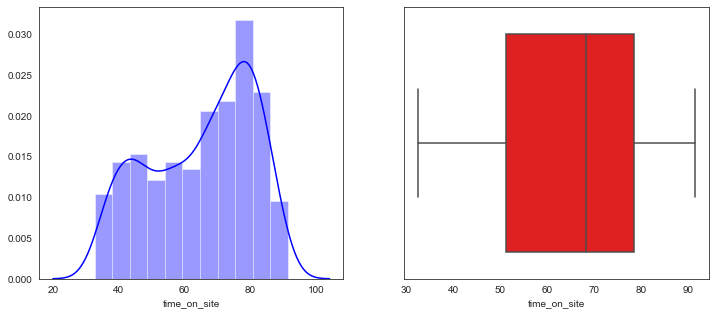

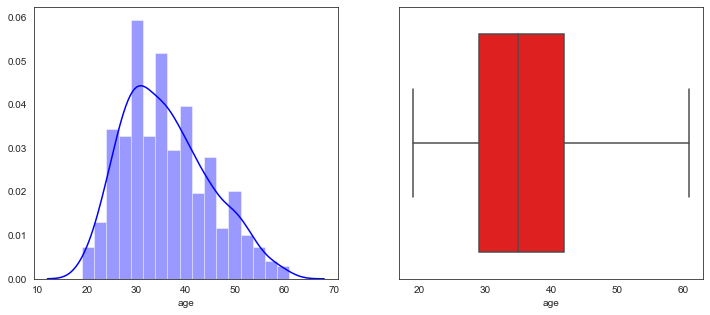

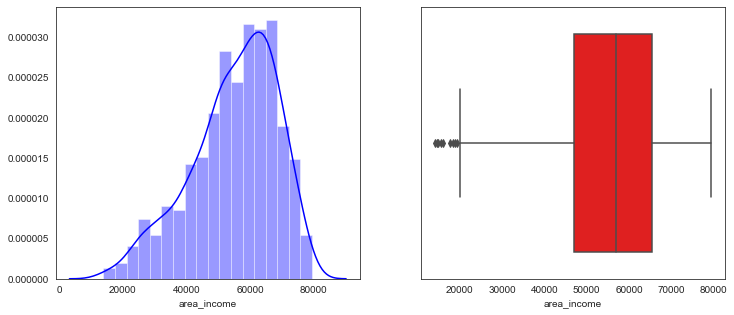

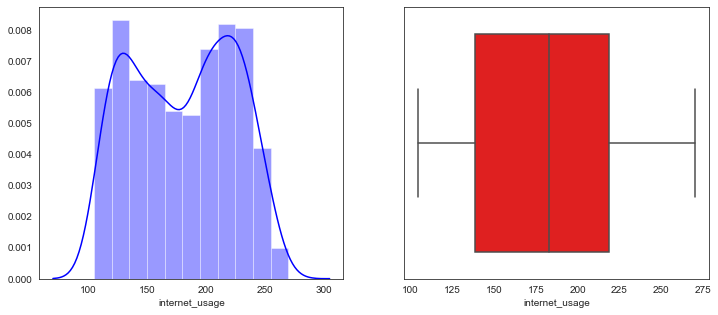

In [21]:
numerical_data= [ad_data.time_on_site, ad_data.age, ad_data.area_income, ad_data.internet_usage]
plots(numerical_data)

Area income has potential outliers. It's distribution is also skewed to the left and is a potential candidate for transformation prior to modeling.

In [22]:
income = ad_data.area_income.describe()
print(income)

IQR = income['75%'] - income['25%']
upper = income['75%'] + (1.5*IQR)
lower = income['25%'] - (1.5*IQR)

print('The upper and lower limits are {} and {}, respectively.'. format(upper, lower))

count     1000.000000
mean     55000.000080
std      13414.634022
min      13996.500000
25%      47031.802500
50%      57012.300000
75%      65470.635000
max      79484.800000
Name: area_income, dtype: float64
The upper and lower limits are 93128.88375000001 and 19373.553749999992, respectively.


In [23]:
low_income = ad_data[ad_data['area_income'] < 19373.55]
low_income

,time_on_site,age,area_income,internet_usage,ad_topic_line,city,male,country,timestamp,clicked
137,49.89,39,17709.98,160.03,Enhanced system-worthy application,East Michele,1,Belize,2016-04-16 12:09,1.0
420,48.09,33,19345.36,180.42,Balanced motivating help-desk,West Travismouth,0,Heard Island and McDonald Islands,2016-05-28 12:38,1.0
522,57.86,30,18819.34,166.86,Horizontal modular success,Estesfurt,0,Algeria,2016-07-08 17:14,1.0
653,64.63,45,15598.29,158.80,Triple-buffered high-level Internet solution,Isaacborough,1,Azerbaijan,2016-06-12 3:11,1.0
678,58.05,32,15879.10,195.54,Total asynchronous architecture,Sanderstown,1,Tajikistan,2016-02-12 10:39,1.0
705,66.26,47,14548.06,179.04,Optional full-range projection,Matthewtown,1,Lebanon,2016-04-25 19:31,1.0
782,68.58,41,13996.50,171.54,Exclusive discrete firmware,New Williamville,1,El Salvador,2016-07-06 12:04,1.0
792,52.67,44,14775.50,191.26,Persevering 5thgeneration knowledge user,New Hollyberg,0,Jersey,2016-05-19 6:37,1.0
970,62.79,36,18368.57,231.87,Total coherent archive,New James,1,Luxembourg,2016-05-30 20:08,1.0


The sample dataset has an average income of 55000USD, including the above observations makes sense especially most are from low income countries and we can make the assumption that the consumers have a high disposable income

### Correlation

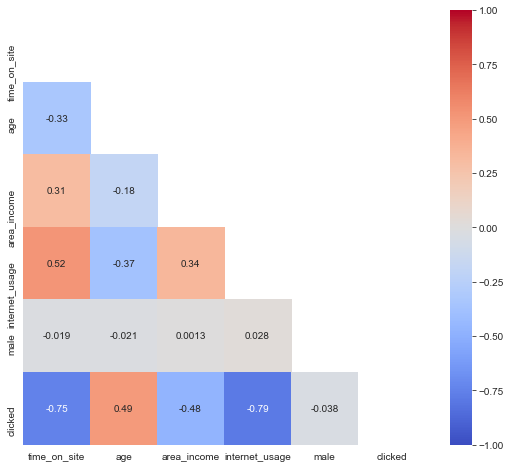

In [24]:
#create a correlation matrix to see what features most correlate with the target
corr = ad_data.corr()

#creating a heatmap and additionally, a boolean mask of zeros and ones
mask = np.zeros_like(corr)   #creates an array of zeros with the same shape as a given array
mask[np.triu_indices_from(mask)] = 1  #returns the indices for the upper triangle of an array


cor_obj = plt.figure(figsize=(9,8))
sns.heatmap(corr, 
           annot=True,
           cmap='coolwarm',
           #fmt = '.0f',
           vmin=-1,
           vmax=1,
           mask = mask)

plt.show()
cor_obj.savefig('correlation2.png')


There seems to be a strong relationship between most features and the target feature except for clicking on an ad

### Further visual exploration of the features

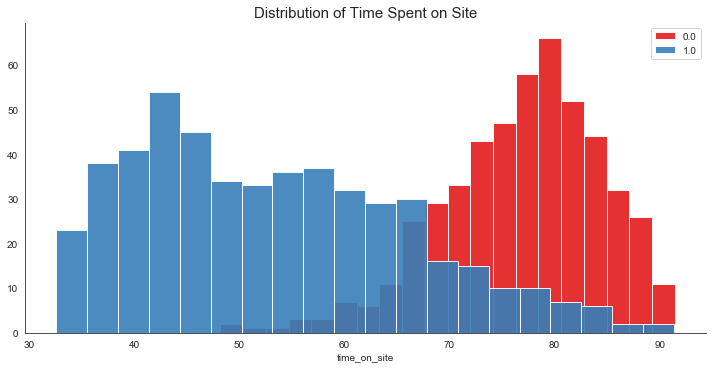

In [25]:
sns.set_style('white')
g = sns.FacetGrid(ad_data, hue='clicked', palette='Set1', height=5, aspect=2)
g = g.map(plt.hist, 'time_on_site', bins=20, alpha=0.9)
plt.title('Distribution of Time Spent on Site', fontsize=15)
plt.legend()
plt.show()
g.savefig('TimeOnSite.png')

**Time on site** -- People who spent less time on the site were more likely to click on the ad. This might be because, people who spent more time on the site probably had a specific goal as to why they clicked on the site for example if the assumption is that this is a lifestyle website, they specifically are on the site to read an article.
Information on what type of website this data is from might be more helpful in deciding how to convert these audience. For example, running a native ad so that they are exposed to the product and hence possibly get them to click on the ad.

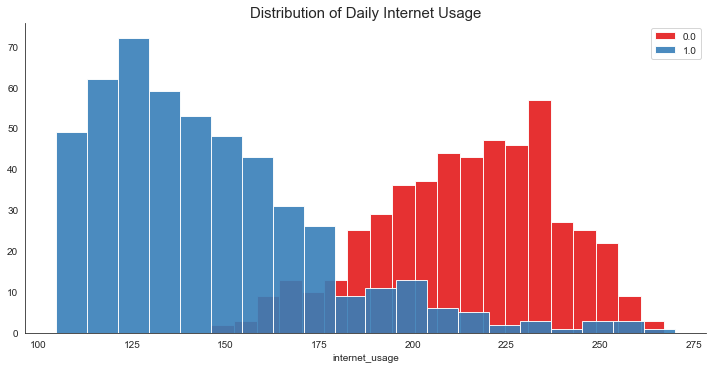

In [26]:
g = sns.FacetGrid(ad_data, hue='clicked', palette='Set1', height=5, aspect=2)
g = g.map(plt.hist, 'internet_usage', bins=20, alpha=0.9)
plt.title('Distribution of Daily Internet Usage', fontsize=15)
plt.legend()
plt.show()
g.savefig ('InternetUsage.png')

**Daily Internet Usage** -- Surprisingly, people who spent more time on the internet were less likely to click on the ad. Actual information on the type of product/service would be more useful in gaining more insight into this.

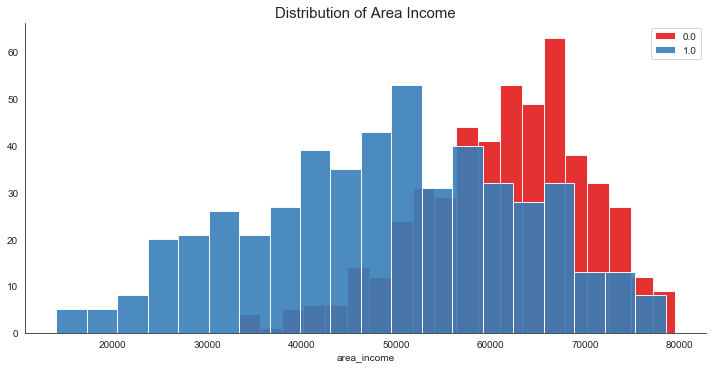

In [27]:
g = sns.FacetGrid(ad_data, hue='clicked', palette='Set1', height=5, aspect=2)
g = g.map(plt.hist, 'area_income', bins=20, alpha=0.9)
plt.title('Distribution of Area Income', fontsize=15)
plt.legend()
plt.show()
g.savefig ('AreaIncome.png')

**Distribution of Area Income** --The overall distribution revealed left-skeweness. However, people who are less likely to click on the ad have a higher income. This partly explains the negative correlation with income.

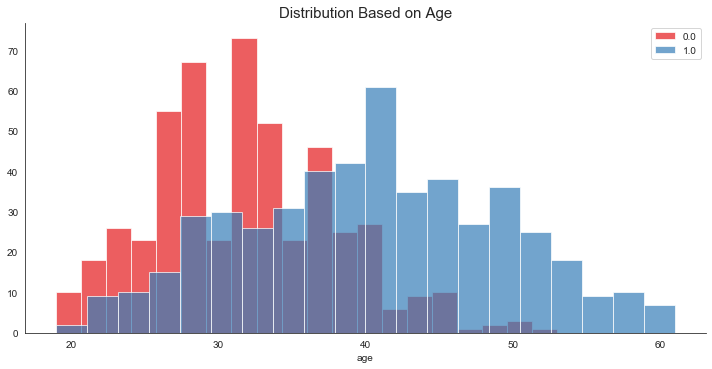

In [28]:
g = sns.FacetGrid(ad_data, hue='clicked', palette='Set1', height=5, aspect=2)
g = g.map(plt.hist, 'age', bins=20, alpha=0.7)
plt.title('Distribution Based on Age', fontsize=15)
plt.legend()
plt.show()
g.savefig ('Age.png')

**Age**-- Overall age distribution is right-skewed. Based on the above chart, younger people are less likely to click on the ad.

## Part 3 - DEVELOP

## Feature Engineering 

### Log Transform 

Skewness tends to adversely affect model's performance and introduces bias to the model, we can log transform the features that are skewed, in this case age and area income. This reduces the distribution's range.

In [29]:
ad_data['log_age'] = np.log(ad_data['age'])
ad_data["log_income"] = np.log(ad_data['area_income'])

### Removing Some Features

Ad Topic Line would require NLP to analyze and Timestamp would require Time Series Analysis. City and Country also would require more analysis. Furthermore, we will exclude location since we have too many countries and cities which would likely not yield useful results.

In [30]:
ad_data = ad_data.drop(['ad_topic_line', 'city', 'country', 'timestamp'], axis = 1)

### Normalization of Features

In [31]:
# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["ad_topic_line", "city", "country"]
numerical_vars = ["time_on_site", "log_income", "internet_usage", "male", "log_age"]
datetime_vars = "timestamp"
target = "clicked"

In [32]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

# Applying the MinMax transformation of the numerical variables
data = pd.DataFrame(data = ad_data)
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

# Show an example of some of the data with scaling applied
data.head()

,time_on_site,age,area_income,internet_usage,male,clicked,log_age,log_income
0,0.617882,35,61833.90,0.916031,0.0,0.0,0.523740,0.855412
1,0.809621,31,68441.85,0.538746,1.0,0.0,0.419696,0.913873
2,0.626721,26,59785.94,0.797433,0.0,0.0,0.268903,0.836019
3,0.706272,29,54806.18,0.854280,1.0,0.0,0.362521,0.785944
4,0.608023,35,73889.99,0.731323,0.0,0.0,0.523740,0.957974


### Preprocessing Categorical features

In [33]:
#using one hot encoding or getting dummy variables from the entire dataset
final_ad_data = pd.get_dummies(data)

-------

## Model Selection

Testing different models to see how they perform. Evaluation is based on

-- F1 Score

### Data Preparation: Training and Testing Sets

In [34]:
X = final_ad_data.drop(['age','clicked', 'area_income'], axis=1)
y = final_ad_data['clicked'] 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

-----

### Logistic Regression

In [36]:
model = LogisticRegression(random_state=42, penalty="l2")

parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9550
Final F-score on the testing data: 0.9577
LogisticRegression(C=1, random_state=42)


The previous step highlighted a value of 1 for the C parameter used in the L2-Regularization. Performing another search with a much narrower search between 0.01 to 1 so as to identify the best parameter.

In [37]:
np.linspace(0.01,10,10)

array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ])

In [38]:
parameters = {"C": [ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89, 10.  ]}

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9725
Final F-score on the testing data: 0.9825
LogisticRegression(C=3.34, random_state=42)


Based on the above examples, the best value for C would likely be between 1 and 2.3 for better accuracy and this can be pursued further.

From the logistic regression above, with the model including most of our features, the best results are:

1. Accuracy of 97.25%
2. F-Score of 98.25%

With L2 regularization with C = 3.34

In [39]:
# Confusion matrix
confmat = confusion_matrix(y_train, best_predictions)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_train, best_predictions), 2))
print("Recall Score:", round(recall_score(y_train, best_predictions), 2))

The Confusion matrix:
 [[396   4]
 [ 18 382]]
Precision Score: 0.99
Recall Score: 0.96


Our false positives will cost us the opportunity to work with another brand and potentially make 20 USD per consumer that is incorrectly classified. Therefore, we need to focus on lowering the false positives.
The model could have lower specificity which increases revenue by 25usd.

In [40]:
def summary_metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    print()
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity/recall/true positive rate
    print("Sensitivity:", round(recall_score(y, y_pred),2))

    # Precision/positive predictive value
    print("Precision:", round(precision_score(y, y_pred),2))

    print("")
    print("DETAILS")
    
    # RETURN ON TP
    print("True Positive:", round((float(TP)*25),2))
    
    # Return on FP
    print("False Positive:", round((float(FP) * -20),2))
    
    # Return on FN
    print("False Negative:", round((float(FN) * 25),2))
    
    # Return on TN
    print("True Negative:", round((float(TN) * 0), 2))
    
    # Return on investment
    investment_return = (TP * 25) + (FP * -20) + (FN * 25) + (TN * 0)
    print("Revenue:", round(float(investment_return),2), "$")


In [41]:
# Getting the metrics from the confusion matrix with our best model on our training set
print(summary_metrics(y_train, best_predictions))

Confusion matrix:
 [[396   4]
 [ 18 382]]

Accuracy: 0.97
Sensitivity: 0.96
Precision: 0.99

DETAILS
True Positive: 9900.0
False Positive: -360.0
False Negative: 100.0
True Negative: 0.0
Revenue: 9640.0 $
None


Text(0, 0.5, 'Frequency')

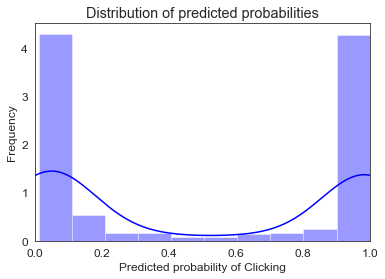

In [42]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]

plt.rcParams["font.size"]= 12
sns.distplot(y_pred_prob, bins=10, color='blue')
plt.xlim(0, 1)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Predicted probability of Clicking")
plt.ylabel("Frequency")

In [43]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]
y_pred_class = np.where(y_pred_prob<0.35,0,1)
summary_metrics(y_train, y_pred_class)

Confusion matrix:
 [[389  11]
 [ 12 388]]

Accuracy: 0.97
Sensitivity: 0.97
Precision: 0.97

DETAILS
True Positive: 9725.0
False Positive: -240.0
False Negative: 275.0
True Negative: 0.0
Revenue: 9760.0 $


By decreasing the threshold from 0.5 to 0.35, the number of false positives significantly reduced, which result in a benefit of about 120USD. The prediction that customers will still click on an ad should be closely monitored especially since that could be provide further insight into the website's audience or more insight into the model.

Looking at test set performance with the model

In [44]:
test_predictions = best_clf.predict(X_test)
summary_metrics(y_test, test_predictions)

Confusion matrix:
 [[95  5]
 [ 4 96]]

Accuracy: 0.96
Sensitivity: 0.96
Precision: 0.95

DETAILS
True Positive: 2375.0
False Positive: -80.0
False Negative: 125.0
True Negative: 0.0
Revenue: 2420.0 $


In [45]:
test_predictions_prob = best_clf.predict_proba(X_test)[:,1]
y_testpred_class = np.where(test_predictions_prob<0.45, 0, 1)

In [46]:
summary_metrics(y_test, y_testpred_class)

Confusion matrix:
 [[95  5]
 [ 3 97]]

Accuracy: 0.96
Sensitivity: 0.97
Precision: 0.95

DETAILS
True Positive: 2375.0
False Positive: -60.0
False Negative: 125.0
True Negative: 0.0
Revenue: 2440.0 $



**Overall revenue from this site would be 2440usd**. This prediction includes 
- **Revenue of 2375usd from true positives**
- **Revenue of 125usd  from false negatives**
- **Lost revenue of 60usd from false positives**

The revenue lost from false positive is less than the revenue we get from false negatives and therefore we would not consider it a huge concern in this case, however, it would be useful to ensure that the false positives are kept at a minimum.

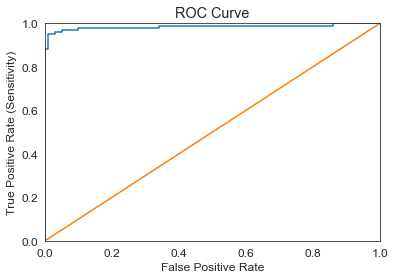

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')


plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.show()

time_on_site      0.374072
internet_usage    0.430364
male              0.004309
log_age           0.104886
log_income        0.086369
dtype: float64


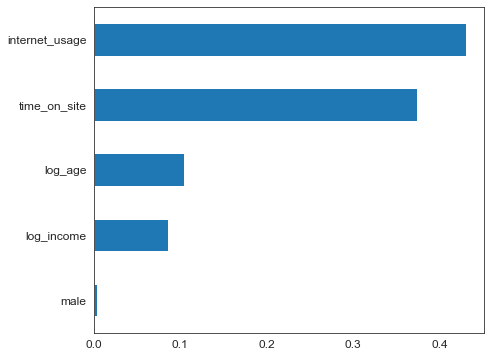

In [48]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, 
                                index=final_ad_data.drop(["clicked", "age", "area_income"],1).columns)
print(feature_importances)

feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))
plt.show()

----

## Recommendations
According to our model, we can already start to choose which websites would perform best based on:

- Daily Internet Usage
- Daily Time on Site
- Age
- Area income


This information can help us start to identify which websites to start testing out the model on. Based on exploratory analysis, the consumers most likely to click on the ad would be on websites where:


-- **Audiences who spend less time on the internet, however, a minimum of 23mins.**

-- **Audiences who spend less time on the website, however, with a minimum of 32mins.**

-- **Audiences who make less than the average income of 55K USD, however, there was an almost normal distribution for those who clicked on the ad. The majority of people who did not click on the ad had a higher income.**

-- **Audiences who were younger were less likely to click on the ad, the distribution for audiences who clicked on the ad was normal. Further investigation would be useful, for example, Company A could run a brand study to for potential reasons.**


By increasing the threshold for the model, false positives were minimized which optimized the model.

-----

## Part 4 - DEPLOY

The output is a model saved in a pickle

In [49]:
best_clf

LogisticRegression(C=3.34, random_state=42)

In [50]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)